# Artificial Neural Networks and Deep Learning

## I ragazzi del Bav

#### Stefano Corti, Andrea Catelli, Alessandro Ciotti, Marco Giovanni Barbero
---

## Dataset manipulation

### 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


### ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load Data

In [ ]:
# Load the .npz file
data = np.load('training_set.npz')

# To list all the arrays stored in the file
print(data.files)

X=data['images']
y=data['labels']


del data

['images', 'labels']


## 🔎 Inspect Data

In [ ]:
# Print the shapes of the loaded datasets
print("Data Shape:", X.shape)
print("Labels Shape:", y.shape)

Data Shape: (13759, 96, 96, 3)
Labels Shape: (13759, 1)


In [ ]:
# Printing the number of classes
print("Number of labels: ",max(y)+1)

Number of labels:  [8]


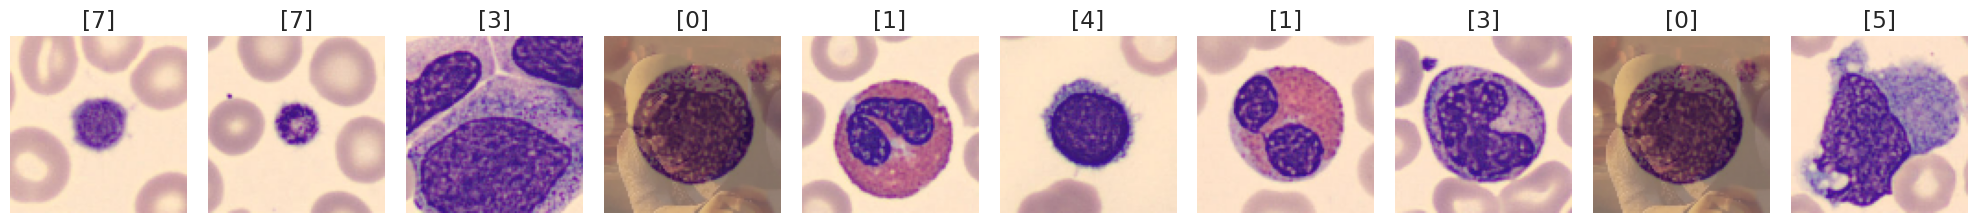

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    2530
1    2381
3    2226
7    1843
5    1393
2    1285
0    1052
4    1049
Name: count, dtype: int64


## 📷 Printing all the images

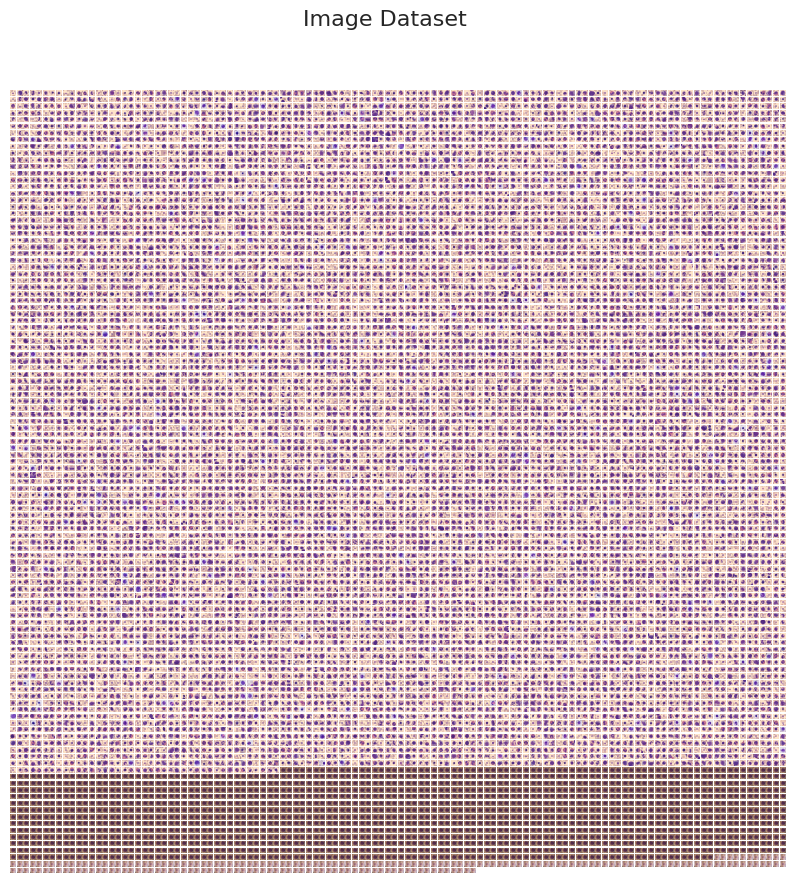

In [ ]:
# Define the number of images and grid size
num_images = len(X)
grid_size = int(np.ceil(np.sqrt(num_images)))  # Smallest square grid size to fit all images

# Dimensions of each thumbnail (adjustable if needed)
thumbnail_size = (16, 16)

# Create the figure for the image grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
fig.suptitle("Image Dataset", fontsize=16)

# Display each image in the grid
for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = X[i]
        ax.imshow(img)  # Display the image
    ax.axis("off")  # Remove axes for cleaner visualization

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust height for the title
plt.show()


## 🔄 Cleaning the dataset

In [ ]:
# Flatten each image into a row, then use np.unique to remove duplicates
print(X.shape)  # Print the shape of the original array
array = X.reshape(X.shape[0], -1)  # Flatten each image (e.g., 96x96x3 -> 1D vector)

# Find unique rows (images) and their indices
unique_flat_images, indices = np.unique(array, axis=0, return_index=True)

# Reconstruct the original array using the unique images
X_clean = X[indices]  # Filter X to keep only unique images
y_clean = y[indices]  # Filter corresponding labels

# Print the shape of the new arrays
print(X_clean.shape)  # Shape of the deduplicated image array
print(y_clean.shape)  # Shape of the deduplicated label array

del X,y

(13759, 96, 96, 3)
(11953, 96, 96, 3)
(11953, 1)


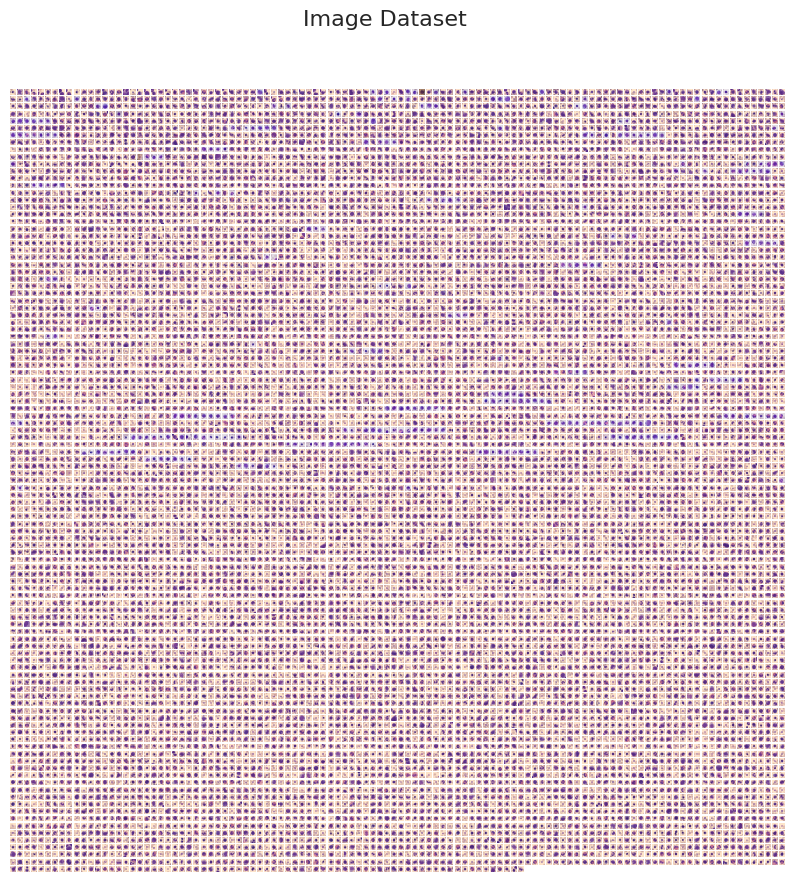

In [ ]:
# Define the number of images and grid size
num_images = len(X_clean)
grid_size = int(np.ceil(np.sqrt(num_images)))  # Smallest square grid size to fit all images

# Dimensions of each thumbnail (adjustable if needed)
thumbnail_size = (16, 16)

# Create the figure for the image grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
fig.suptitle("Image Dataset", fontsize=16)

# Display each image in the grid
for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = X_clean[i]
        ax.imshow(img)  # Display the image
    ax.axis("off")  # Remove axes for cleaner visualization

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust height for the title
plt.show()


In [ ]:
np.savez_compressed("cleaned_dataset.npz", X=X_clean, y=y_clean)

## ⚖️ Balancing the dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=150,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
def augment_to_balance(X, y, target_count):
    """
    Augments images to balance the dataset by generating new images for underrepresented classes.

    Parameters:
    X (numpy array): Array of images.
    y (numpy array): Array of labels corresponding to the images.
    target_count (int): Desired number of images per class.

    Returns:
    np.array: Balanced array of images.
    np.array: Balanced array of corresponding labels.
    """
    unique_classes = np.unique(y)
    X_balanced, y_balanced = [], []

    for cls in unique_classes:
        # Filter the images of the current class
        class_indices = np.where(y == cls)[0]
        X_class = X[class_indices]
        num_needed = target_count - len(X_class)

        # Add original images of the current class to the balanced list
        X_balanced.extend(X_class)
        y_balanced.extend([cls] * len(X_class))

        # Generate augmented images to reach the target count
        for i in range(num_needed):
            # Select a random image from the current class
            img = X_class[np.random.randint(len(X_class))]
            # Generate a new augmented image using a data generator
            img_aug = next(datagen.flow(np.expand_dims(img, 0), batch_size=1))[0]
            X_balanced.append(img_aug)
            y_balanced.append(cls)

    return np.array(X_balanced), np.array(y_balanced)


In [ ]:
# Number of images per label
max_count = max([np.sum(y_clean == cls) for cls in np.unique(y_clean)]) #BALANCED DATASET, 2330 IMAGES FOR EACH LABEL

# Apply the function to balance the dataset
X_balanced, y_balanced = augment_to_balance(X_clean, y_clean, max_count)

# Print the resulting shapes and maximum count
print("Max count: ", max_count)
print("X balanced shape: ", X_balanced.shape)
print("Y balanced shape: ", y_balanced.shape)

Max count:  2330
X balanced shape:  (18640, 96, 96, 3)
Y balanced shape:  (18640,)


In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_balanced, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
0    2330
1    2330
2    2330
3    2330
4    2330
5    2330
6    2330
7    2330
Name: count, dtype: int64


## 💾 Saving balanced dataset

In [ ]:
np.savez_compressed("balanced_dataset.npz", images=X_balanced, labels=y_balanced)
del X_balanced, y_balanced

In [ ]:
# Number of images per label
max_count = 5000

# Apply the function to balance the dataset
X_balanced_5000, y_balanced_5000 = augment_to_balance(X_clean, y_clean, max_count)

# Print the resulting shapes and maximum count
print("Max count: ", max_count)
print("X balanced shape: ", X_balanced_5000.shape)
print("Y balanced shape: ", y_balanced_5000.shape)

## 💾 Saving balanced dataset with 5000 images for class

In [ ]:
np.savez_compressed("balanced_dataset_5000.npz", images=X_balanced_5000, labels=y_balanced_5000)
del X_balanced_5000, y_balanced_5000

## ✂️ Cropping dataset

In [ ]:
# Load the .npz file
data = np.load('cleaned_dataset.npz')

# To list all the arrays stored in the file
print(data.files)

X_clean=data['X']
y_clean=data['y']


del data

['X', 'y']


In [ ]:
def cropping(X, crop_size):
    """
    Crop a dataset of images to the specified size.

    Parameters:
    X (numpy.ndarray): The input dataset of images with shape (n_samples, height, width, channels).
    crop_size (int): The size to crop the images to (crop_size x crop_size).

    Returns:
    numpy.ndarray: The cropped dataset of images.
    """
    cropped_images = []

    for image in X:
        # Getting the shape of the image
        height, width, _ = image.shape

        # Crop the image to the center (adjust for different sizes)
        top = (height - crop_size) // 2
        left = (width - crop_size) // 2
        cropped_image = image[top:top + crop_size, left:left + crop_size]

        # Append the cropped image to the list
        cropped_images.append(cropped_image)

    return np.array(cropped_images) # Convertion to numpy array

In [ ]:
# Cropping the images
cropped_images = cropping(X_clean, 80)
print("Image shape before cropping: ", X_clean.shape)
print("Cropped images shape:", cropped_images.shape)

Image shape before cropping:  (11953, 96, 96, 3)
Cropped images shape: (11953, 80, 80, 3)


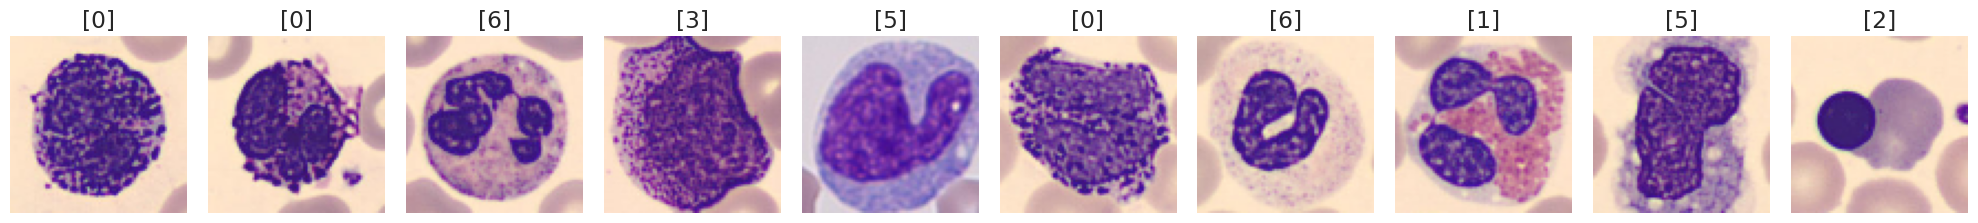

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(cropped_images)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(cropped_images[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_clean[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 💾 Saving the cropped dataset

In [ ]:
np.savez_compressed('cropped_80_dataset.npz', images=cropped_images, labels=y_clean)
del cropped_images

## Binary Masks via K-means

In [ ]:
import cv2
from sklearn.cluster import KMeans

def segment_blood_cells(image_data):
    """
    Perform unsupervised segmentation of blood cells in a given image, ensuring the cells are always white.

    Parameters:
    image_data (numpy.ndarray): A 4D array containing the images, in the format (num_images, height, width, channels).

    Returns:
    list of numpy.ndarray: A list of segmentation masks, one for each input image.
    """
    segmentation_masks = []

    for image in image_data:
        # Reshape the image to 2D for clustering
        image_2d = image.reshape(-1, image.shape[2])

        # Apply k-means clustering
        kmeans = KMeans(n_clusters=2, random_state=42)
        labels = kmeans.fit_predict(image_2d)

        # Reshape the labels back to the original image shape
        segmentation_mask = labels.reshape(image.shape[:2])

        # Identify the cluster that corresponds to the blood cells
        # Assume the blood cells are in the center of the image
        center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
        center_cluster = segmentation_mask[center_y, center_x]

        # Create a binary segmentation mask with the blood cells as white
        segmentation_mask = (segmentation_mask == center_cluster).astype(np.uint8)

        segmentation_masks.append(segmentation_mask)

    return segmentation_masks

#### This binary mask created via K-means should be multipled by the traininig dataset and feed in a Neural Network

In [ ]:
# Run the segmentation
segmentation_masks_train = segment_blood_cells(X_clean)

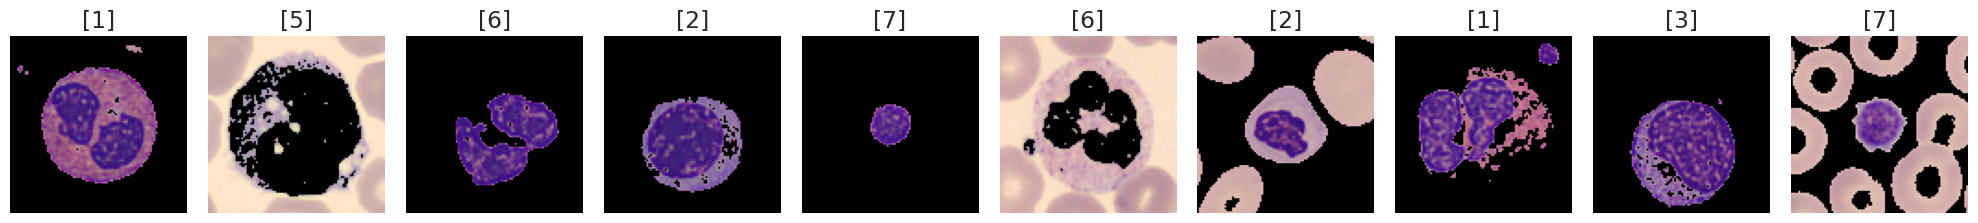

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_clean)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]

    # Ensure the segmentation mask has the same dimensions as the image (3 channels)
    mask = np.expand_dims(segmentation_masks_train[idx], axis=-1)  # Shape: (height, width, 1)
    mask_rgb = np.repeat(mask, 3, axis=-1)  # Convert to 3 channels

    # Apply the mask to the image
    masked_image = X_clean[idx] * (mask_rgb / 255.0)  # Ensure scaling is consistent

    # Display the masked image
    ax.imshow(masked_image)  # No colormap applied
    ax.set_title(f'{y_clean[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()


It is possible to notice that the K-means algorithm was not able to always corretly create the mask and identifying the cell

## 🚀 Train set Augmentation

In [ ]:
data = np.load("balanced_dataset_5000.npz")
X_train = data['images']
y_train = data['labels']

aug = kcv.layers.RandAugment((0,255), 6, 0.5, 0.2, seed = seed)

X_train = aug(X_train).numpy()

np.savez_compressed("Augmented_train_randAugment_5000img.npz", images=X_train, labels=y_train)

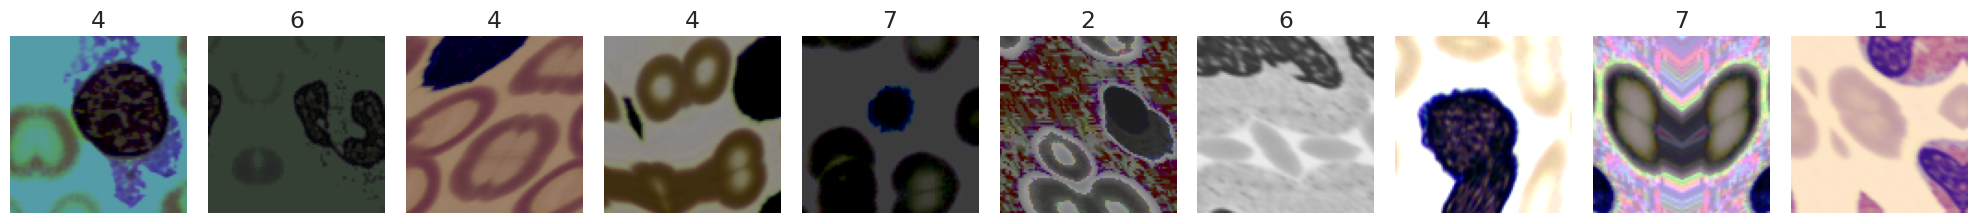

In [13]:
# Display a sample of images from the training-validation dataset

num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(X_train[idx].astype(np.uint8))
    ax.set_title(f'{y_train[idx]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()